In [309]:
import sys

sys.path.append(
    "C:\\Users\\Wyss User\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages"
)

import biolib
import gzip
import math
import os
import requests
import tspex
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xml.etree.ElementTree as ET

from io import StringIO
from IPython.display import Image
from matplotlib_venn import venn2
from matplotlib_venn import venn3
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import mannwhitneyu
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [310]:
ALL_FASTA_OUTPUT_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\all_fasta.fasta"
ALL_TARGETS_OUTPUT_DIRECTORY = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\tmhmm_all_targets"
)

ASSAY_LIST_PATH = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\assay-list-olink-explore-3072.xlsx"
)
BRAIN_RNA_SEQ_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\brain_rna_seq.csv"
HGNC_IDS = (
    "https://ftp.ebi.ac.uk/pub/databases/genenames/hgnc/tsv/hgnc_complete_set.txt"
)
MICROGLIA_FASTA_OUTPUT_PATH = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\microglia_fasta.fasta"
)
MATURE_ASTROCYTE_FASTA_OUTPUT_PATH = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\mature_astrocyte_fasta.fasta"
)
OLIGODENDROCYTE_FASTA_OUTPUT_PATH = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\oligodendrocyte_fasta.fasta"
)
PLATE_LAYOUT_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\Plate Layout.xlsx"


RAW_DATA_FILE = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\LCSET_28343_10-4-2023_EXTENDED_NPX_2023-10-20.csv"
TMHMM_OUTPUT = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\tmhmm_all_targets\\TMRs.gff3"
)
UNIPROT_TO_FASTA_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\uniprotkb_proteome_UP000005640_2023_11_20.fasta.gz"


PANELS = [
    "Cardiometabolic",
    "Cardiometabolic_II",
    "Inflammation",
    "Inflammation_II",
    "Neurology",
    "Neurology_II",
    "Oncology",
    "Oncology_II",
]


UNIMPORTANT_COLUMNS = [
    "Index",
    "OlinkID",
    "Panel_Lot_Nr",
    "PlateID",
    "WellID",
    "Normalization",
    "Processing_StartDate",
    "Processing_EndDate",
    "AnalyzerID",
    "ExploreVersion",
]


X_AXIS_ORDER = [
    "SEC Fract 6 ",
    "SEC Fract 7",
    "SEC Fract 8",
    "SEC Fract 9",
    "SEC Fract 10",
    "SEC Fract 11",
    "SEC Fract 12",
    "SEC Fract 13",
    "SEC Fract 14",
    "SEC Fract 15",
    "CSF A Internal EV",
    "CSF B Internal EV",
    "CSF C Internal EV",
    "CSF D Internal EV",
    "Plas A Internal EV",
    "Plas B Internal EV",
    "Plas C Internal EV",
    "Plasma D Internal EV",
]

CSF_SAMPLES = [
    "SEC Fract 6 ",
    "SEC Fract 7",
    "SEC Fract 8",
    "SEC Fract 9",
    "SEC Fract 10",
    "SEC Fract 11",
    "SEC Fract 12",
    "SEC Fract 13",
    "SEC Fract 14",
    "SEC Fract 15",
    "CSF A Internal EV",
    "CSF B Internal EV",
    "CSF C Internal EV",
    "CSF D Internal EV",
]

In [311]:
assay_list = pd.read_excel(ASSAY_LIST_PATH)


# Map UniProt IDs to the corresponding FASTA sequences


def parse_gz_file(file_path):
    protein_dict = {}
    current_uniprot_id = None
    current_sequence = ""
    with gzip.open(file_path, "rt") as f:
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                if current_uniprot_id is not None:
                    protein_dict[current_uniprot_id] = current_sequence
                    current_sequence = ""
                if "|" in line:
                    current_uniprot_id = line.split("|")[1].strip()
                else:
                    print(f"Skipping line without expected format: {line}")
                    current_uniprot_id = None
            else:
                current_sequence += line
        if current_uniprot_id is not None:
            protein_dict[current_uniprot_id] = current_sequence
    return protein_dict

protein_data = parse_gz_file(UNIPROT_TO_FASTA_PATH)

assay_list["Sequence"] = assay_list["UniProt ID"].map(
    lambda x: protein_data.get(x, "N/A")
)

In [312]:
# # Create a FASTA file containing the information for the OLINK targets

# def export_fasta(output_path, df):
#     with open(output_path, "w") as output_file:
#         for index, row in df.iterrows():
#             output_file.write(f'>{row["UniProt ID"]}\n')
#             output_file.write(f'{row["Sequence"]}\n')
# export_fasta(ALL_FASTA_OUTPUT_PATH, assay_list)

# # Use the TMHMM deep learning model to predict the localication of each of the OLINK targets
# deeptmhmm = biolib.load("DTU/DeepTMHMM")
# def tmhmm_localization(targets, output_directory):
#     if not os.path.exists(output_directory):
#         os.makedirs(output_directory)
#     os.chdir(output_directory)
#     with open("query.fasta", "w") as fasta_file:
#         for _, row in targets.iterrows():
#             sequence = row["Sequence"]
#             uniprot_id = row["UniProt ID"]
#             fasta_line = f">{uniprot_id}\n{sequence}\n"
#             fasta_file.write(fasta_line)
#         biolib.utils.STREAM_STDOUT = True
#         deeptmhmm_job = deeptmhmm.cli(
#             args="--fasta query.fasta", machine="local"
#         )
#         deeptmhmm_job.save_files(output_directory)

# tmhmm_localization(assay_list, ALL_TARGETS_OUTPUT_DIRECTORY)

In [313]:
# Import the TMHMM output
with open(TMHMM_OUTPUT, "r") as gff_file:
    gff_lines = gff_file.readlines()

# Create lists to store data
uniprot_ids = []
region_locations = []
region_starts = []
region_ends = []

# Process each line in the GFF file
for line in gff_lines:
    # Skip lines starting with "//"
    if not line.startswith("//"):
        # Split the line by tabs
        columns = line.strip().split("\t")

        # Ensure that the line has enough columns
        if len(columns) >= 4:
            # Extract information from the columns
            uniprot_id = columns[0]
            region_location = columns[1]
            region_start = int(columns[2])
            region_end = int(columns[3])

            uniprot_ids.append(uniprot_id)
            region_locations.append(region_location)
            region_starts.append(region_start)
            region_ends.append(region_end)

# Create a new dataframe
data = {
    "UniProt ID": uniprot_ids,
    "Region Location": region_locations,
    "Region Start": region_starts,
    "Region End": region_ends,
}

tmhmm_df = pd.DataFrame(data)

tm_tmhmm = tmhmm_df[tmhmm_df["Region Location"] == "TMhelix"]
outside_tmhmm = tmhmm_df[tmhmm_df["Region Location"] == "outside"]
inside_tmhmm = tmhmm_df[tmhmm_df["Region Location"] == "inside"]

tm_uniprots = set(tm_tmhmm["UniProt ID"])
inside_uniprots = set(inside_tmhmm["UniProt ID"])
outside_uniprots = set(outside_tmhmm["UniProt ID"])

inside_uniprots = inside_uniprots - tm_uniprots - outside_uniprots
outside_uniprots = outside_uniprots - tm_uniprots - inside_uniprots

In [374]:
brain_rna_seq = pd.read_csv(BRAIN_RNA_SEQ_PATH)

# Find the mean expression of each cell type 
astrocyte_cols = [
    "astrocytes_mature_1",
    "astrocytes_mature_2",
    "astrocytes_mature_3",
    "astrocytes_mature_4",
    "astrocytes_mature_5",
    "astrocytes_mature_6",
    "astrocytes_mature_7",
    "astrocytes_mature_8",
    "astrocytes_mature_9",
    "astrocytes_mature_10",
    "astrocytes_mature_11",
    "astrocytes_mature_12",
]
brain_rna_seq['astrocytes'] = brain_rna_seq[astrocyte_cols].mean(axis=1)

endothelial_cols = ["endothelial_1", "endothelial_2"]
brain_rna_seq['endothelial'] = brain_rna_seq[endothelial_cols].mean(axis=1)

microglia_cols = ["microglla_1", "microglla_2", "microglla_3"]
brain_rna_seq['microglia'] = brain_rna_seq[microglia_cols].mean(axis=1)

oligodendrocyte_cols = [
    "oligodendrocytes_1",
    "oligodendrocytes_2",
    "oligodendrocytes_3",
    "oligodendrocytes_4",
    "oligodendrocytes_5",
]
brain_rna_seq['oligodendrocytes'] = brain_rna_seq[oligodendrocyte_cols].mean(axis=1)

brain_rna_seq["neurons"] = brain_rna_seq["neurons_1"]

brain_rna_seq = brain_rna_seq[["id", "astrocytes", "endothelial", "microglia", "neurons", "oligodendrocytes"]]

brain_rna_seq.set_index("id", inplace=True)


In [375]:
brain_rna_seq_no_duplicates = brain_rna_seq[~brain_rna_seq.index.duplicated()]

In [376]:
expression_data = brain_rna_seq_no_duplicates.loc[(brain_rna_seq_no_duplicates > 0).any(axis = 1)]

In [377]:
expression_data.shape

(21763, 5)

In [378]:
expression_data.head()

,astrocytes,endothelial,microglia,neurons,oligodendrocytes
id,,,,,
HGNC:44003,0.100000,0.100000,0.100000,0.100000,0.1
HGNC:5,0.100000,0.100000,0.100000,0.100000,0.1
HGNC:37133,0.166005,0.173021,0.245152,0.495489,0.1
HGNC:24086,0.100000,0.100000,0.100000,0.100000,0.1
HGNC:25100,1.218443,0.100000,0.246458,0.100000,0.1


In [379]:
tso = tspex.TissueSpecificity(expression_data, 'tau', log=True)

In [380]:
tso.tissue_specificity.quantile([0.5, 0.75, 0.95])

0.50    0.3590
0.75    0.5847
0.95    0.8447
dtype: float64

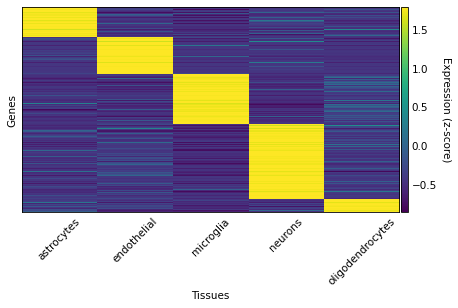

In [381]:
tso.plot_heatmap(threshold=0.8, sort_genes=True, use_zscore=True, gene_names=False)

plt.show()

In [322]:
tso = tspex.TissueSpecificity(expression_data, 'spm', log=True)


In [323]:
tso.tissue_specificity.head()

,astrocytes,endothelial,microglia,oligodendrocytes,neurons
id,,,,,
HGNC:44003,0.4472,0.4472,0.4472,0.4472,0.4472
HGNC:5,0.4472,0.4472,0.4472,0.4472,0.4472
HGNC:37133,0.2966,0.3082,0.4234,0.1840,0.7771
HGNC:24086,0.4472,0.4472,0.4472,0.4472,0.4472
HGNC:25100,0.9452,0.1131,0.2613,0.1131,0.1131


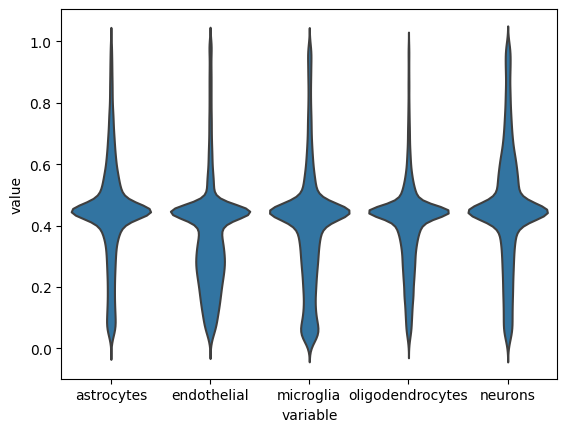

In [324]:
sns.violinplot(x="variable", y="value", inner=None, scale="count", color='C0',
               data=tso.tissue_specificity.melt());
plt.show()

In [325]:
microglia_targets = tso.tissue_specificity.query('microglia >= 0.85')
oligodendrocyte_targets = tso.tissue_specificity.query('oligodendrocytes >= 0.85')
neuron_targets = tso.tissue_specificity.query('neurons >= 0.85')
astrocyte_targets = tso.tissue_specificity.query('astrocytes >= 0.85')

microglia_targets_hgnc = microglia_targets.index.tolist()
oligodendrocyte_targets_hgnc = oligodendrocyte_targets.index.tolist()
neuron_targets_hgnc = neuron_targets.index.tolist()
astrocyte_targets_hgnc = astrocyte_targets.index.tolist()

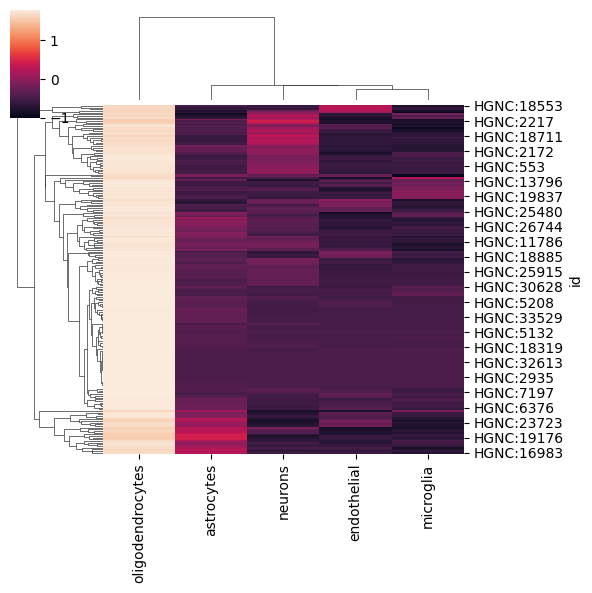

In [385]:
sns.clustermap(oligodendrocyte_targets, figsize=(6,6), z_score=0);

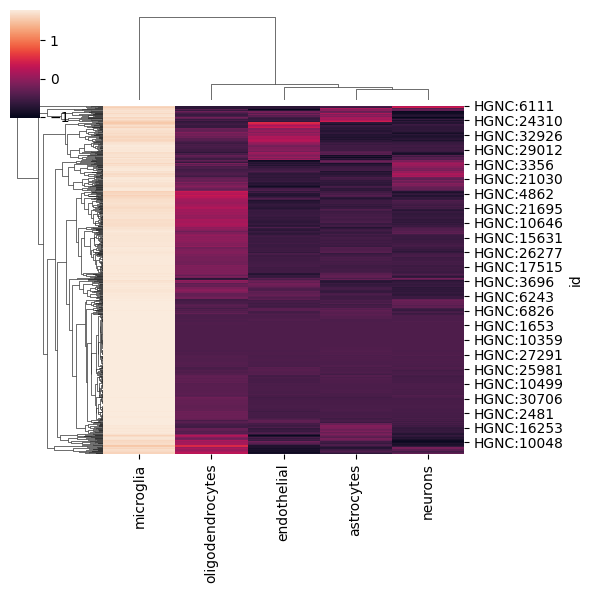

In [372]:
sns.clustermap(microglia_targets, figsize=(6,6), z_score=0);

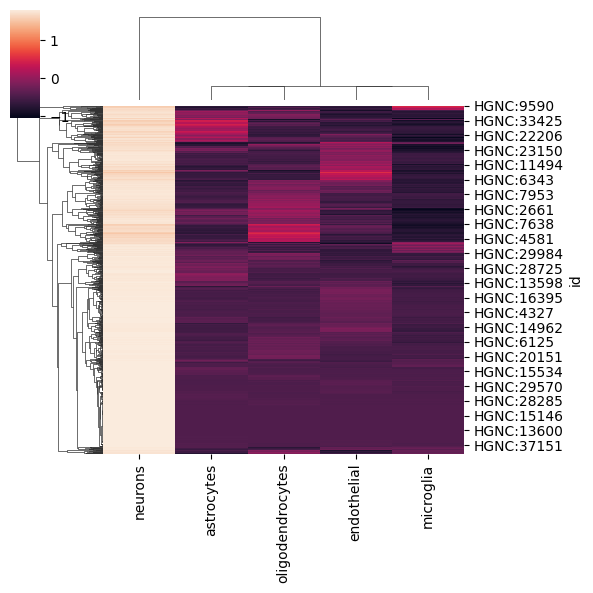

In [326]:
sns.clustermap(neuron_targets, figsize=(6,6), z_score=0);

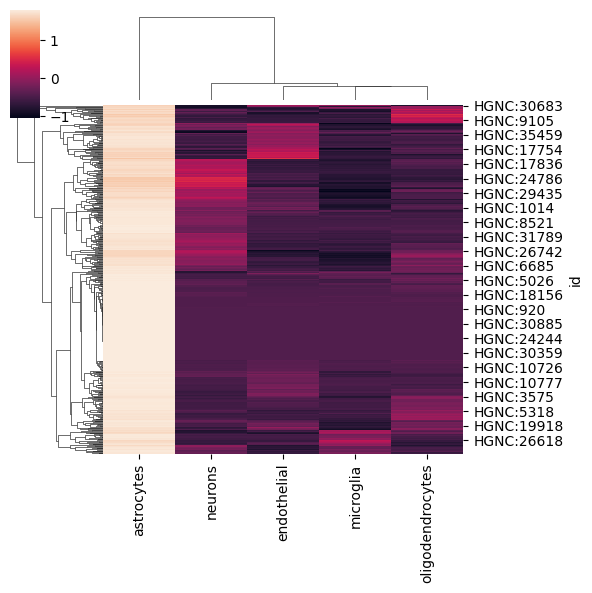

In [327]:
sns.clustermap(astrocyte_targets, figsize=(6,6), z_score=0);

In [328]:
# Map the HGNC IDs to the UniProt IDs

# This database that maps HGNC IDs to UniProt IDs doesn't have all the UniProt IDs we need, resulting in some targets being dropped unnecessarily
response = requests.get(HGNC_IDS)
content = response.text
file_like_object = StringIO(content)
uniprot_ids = pd.read_csv(file_like_object, sep="\t", low_memory=False)

# Create a list of UniProt IDs for each cell type

astrocyte_uniprots = uniprot_ids[
    uniprot_ids["hgnc_id"].isin(astrocyte_targets_hgnc)
]
oligodendrocyte_uniprots = uniprot_ids[
    uniprot_ids["hgnc_id"].isin(oligodendrocyte_targets_hgnc)
]

microglia_uniprots = uniprot_ids[
    uniprot_ids["hgnc_id"].isin(microglia_targets_hgnc)
]

neuron_uniprots = uniprot_ids[
    uniprot_ids["hgnc_id"].isin(neuron_targets_hgnc)
]

In [329]:
astrocyte_uniprots = list(astrocyte_uniprots["uniprot_ids"])
oligodendrocyte_uniprots = list(oligodendrocyte_uniprots["uniprot_ids"])
microglia_uniprots = list(microglia_uniprots["uniprot_ids"])
neuron_uniprots = list(neuron_uniprots["uniprot_ids"])

In [332]:
# Clean up the raw OLINK data file and map the sample locations to their barcodes
plate_layout = pd.read_excel(PLATE_LAYOUT_PATH, index_col=0)
raw_data = pd.read_csv(RAW_DATA_FILE, sep=";")
raw_data = raw_data.drop(UNIMPORTANT_COLUMNS, axis=1)

data = pd.merge(raw_data, plate_layout, how="left", on="SampleID")

# Normalize the data according to plate negative controls
ctrl_dict = {}
for panel in PANELS:
    df = data[(data["Panel"] == panel)]
    plate_ctrl = df[
        (df["Sample_Type"] == "PLATE_CONTROL")
        & (df["Assay"] == "Amplification control 1")
    ]["NPX"].median()
    ctrl_dict[panel] = plate_ctrl
data["Delta"] = data.apply(
    lambda row: row["NPX"] - ctrl_dict[row["Panel"]],
    axis=1,
)

# Linearize the NPX values
data["Linear Delta"] = data["Delta"].map(lambda x: 2**x)

# Identify and drop replicate assays
vc = data[["SampleID", "Sample_Type", "UniProt"]].value_counts()
vc = vc[vc > 1]

unique_uniprot_values = vc.index.get_level_values("UniProt").unique()
uniprot_list = unique_uniprot_values.tolist()

raw_data_no_reps = data[~data["UniProt"].isin(uniprot_list)].copy()

# raw_data_no_reps["Delta"] = raw_data_no_reps.apply(
#     lambda row: row["NPX"] - ctrl_dict[row["Panel"]],
#     axis=1,
# )

# Create a tidy dataframe for the delta values
tidy_data = raw_data_no_reps[raw_data_no_reps["Sample_Type"] == "SAMPLE"].pivot(
    columns="UniProt", index=["SampleID", "Health", "Sample"], values="Linear Delta"
)

Text(0.5, 1.0, 'Assays with Significant Differences Between Samples')

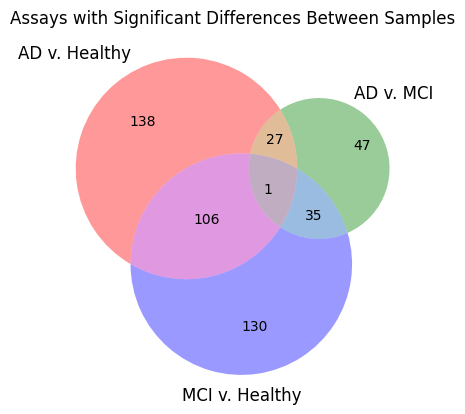

In [333]:
# Mann-Whitney U Test to determine significant difference between AD/MCI/Healthy samples in all fractions

assay_list = list(tidy_data.columns)

healthy_df = tidy_data[tidy_data.index.get_level_values("Health") == "Healthy"]
mci_df = tidy_data[tidy_data.index.get_level_values("Health") == "MCI"]
ad_df = tidy_data[tidy_data.index.get_level_values("Health") == "AD"]

ad_healthy_mannwhitneyu = pd.DataFrame(columns=["Assay", "p-value", "Statistic"])
ad_mci_mannwhitneyu = pd.DataFrame(columns=["Assay", "p-value", "Statistic"])
mci_healthy_mannwhitneyu = pd.DataFrame(columns=["Assay", "p-value", "Statistic"])

for assay in assay_list:
    healthy_assays = list(healthy_df[assay])
    mci_assays = list(mci_df[assay])
    ad_assays = list(ad_df[assay])

    ad_healthy_statistic, ad_healthy_p_value = mannwhitneyu(ad_assays, healthy_assays)
    ad_mci_statistic, ad_mci_p_value = mannwhitneyu(ad_assays, mci_assays)
    mci_healthy_statistic, mci_healthy_p_value = mannwhitneyu(
        mci_assays, healthy_assays
    )

    ad_healthy_result_row = pd.DataFrame(
        {
            "Assay": [assay],
            "p-value": [ad_healthy_p_value],
            "Statistic": [ad_healthy_statistic],
        }
    )
    ad_mci_result_row = pd.DataFrame(
        {"Assay": [assay], "p-value": [ad_mci_p_value], "Statistic": [ad_mci_statistic]}
    )
    mci_healthy_result_row = pd.DataFrame(
        {
            "Assay": [assay],
            "p-value": [mci_healthy_p_value],
            "Statistic": [mci_healthy_statistic],
        }
    )

    ad_healthy_mannwhitneyu = pd.concat(
        [ad_healthy_mannwhitneyu, ad_healthy_result_row], ignore_index=True
    )
    ad_mci_mannwhitneyu = pd.concat(
        [ad_mci_mannwhitneyu, ad_mci_result_row], ignore_index=True
    )
    mci_healthy_mannwhitneyu = pd.concat(
        [mci_healthy_mannwhitneyu, mci_healthy_result_row], ignore_index=True
    )

ad_healthy_sig_dif = ad_healthy_mannwhitneyu[ad_healthy_mannwhitneyu["p-value"] < 0.05]
ad_mci_sig_dif = ad_mci_mannwhitneyu[ad_mci_mannwhitneyu["p-value"] < 0.05]
mci_healthy_sig_dif = mci_healthy_mannwhitneyu[
    mci_healthy_mannwhitneyu["p-value"] < 0.05
]

ad_healthy_sig_dif_assays = set(ad_healthy_sig_dif["Assay"])
ad_mci_sig_dif_assays = set(ad_mci_sig_dif["Assay"])
mci_healthy_sig_dif_assays = set(mci_healthy_sig_dif["Assay"])

venn3(
    [ad_healthy_sig_dif_assays, ad_mci_sig_dif_assays, mci_healthy_sig_dif_assays],
    set_labels=("AD v. Healthy", "AD v. MCI", "MCI v. Healthy"),
)
plt.title("Assays with Significant Differences Between Samples")

In [334]:
# Mann-Whitney U Test to determine significant difference between AD/MCI/Healthy samples in EV/secreted fractions

assay_list = list(tidy_data.columns)

ad_healthy_ev_mannwhitneyu = pd.DataFrame(columns=["Assay", "p-value", "Statistic"])
ad_mci_ev_mannwhitneyu = pd.DataFrame(columns=["Assay", "p-value", "Statistic"])
mci_healthy_ev_mannwhitneyu = pd.DataFrame(columns=["Assay", "p-value", "Statistic"])

ad_healthy_secreted_mannwhitneyu = pd.DataFrame(columns=["Assay", "p-value", "Statistic"])
ad_mci_secreted_mannwhitneyu = pd.DataFrame(columns=["Assay", "p-value", "Statistic"])
mci_healthy_secreted_mannwhitneyu = pd.DataFrame(columns=["Assay", "p-value", "Statistic"])

for assay in assay_list:
    tidy_data_assay = tidy_data[assay]
    healthy_assay_ev_peak = (
        (tidy_data_assay.index.get_level_values("Sample") == "SEC Fract 9")
        | (tidy_data_assay.index.get_level_values("Sample") == "SEC Fract 10")
    ) & (tidy_data_assay.index.get_level_values("Health") == "Healthy")
    mci_assay_ev_peak = (
        (tidy_data_assay.index.get_level_values("Sample") == "SEC Fract 9")
        | (tidy_data_assay.index.get_level_values("Sample") == "SEC Fract 10")
    ) & (tidy_data_assay.index.get_level_values("Health") == "MCI")
    ad_assay_ev_peak = (
        (tidy_data_assay.index.get_level_values("Sample") == "SEC Fract 9")
        | (tidy_data_assay.index.get_level_values("Sample") == "SEC Fract 10")
    ) & (tidy_data_assay.index.get_level_values("Health") == "AD")
    healthy_assay_ev_values = tidy_data_assay.loc[healthy_assay_ev_peak].values
    mci_assay_ev_values = tidy_data_assay.loc[mci_assay_ev_peak].values
    ad_assay_ev_values = tidy_data_assay.loc[ad_assay_ev_peak].values
    ad_healthy_ev_statistic, ad_healthy_ev_p_value = mannwhitneyu(
        ad_assay_ev_values, healthy_assay_ev_values
    )
    ad_mci_ev_statistic, ad_mci_ev_p_value = mannwhitneyu(
        ad_assay_ev_values, mci_assay_ev_values
    )
    mci_healthy_ev_statistic, mci_healthy_ev_p_value = mannwhitneyu(
        mci_assay_ev_values, healthy_assay_ev_values
    )
    ad_healthy_ev_result_row = pd.DataFrame(
        {
            "Assay": [assay],
            "p-value": [ad_healthy_ev_p_value],
            "Statistic": [ad_healthy_ev_statistic],
        }
    )
    ad_mci_ev_result_row = pd.DataFrame(
        {
            "Assay": [assay],
            "p-value": [ad_mci_ev_p_value],
            "Statistic": [ad_mci_ev_statistic],
        }
    )
    mci_healthy_ev_result_row = pd.DataFrame(
        {
            "Assay": [assay],
            "p-value": [mci_healthy_ev_p_value],
            "Statistic": [mci_healthy_ev_statistic],
        }
    )
    ad_healthy_ev_mannwhitneyu = pd.concat(
        [ad_healthy_ev_mannwhitneyu, ad_healthy_ev_result_row], ignore_index=True
    )
    ad_mci_ev_mannwhitneyu = pd.concat(
        [ad_mci_ev_mannwhitneyu, ad_mci_ev_result_row], ignore_index=True
    )
    mci_healthy_ev_mannwhitneyu = pd.concat(
        [mci_healthy_ev_mannwhitneyu, mci_healthy_ev_result_row], ignore_index=True
    )
    healthy_assay_secreted = (
        (tidy_data_assay.index.get_level_values("Sample") == "SEC Fract 14")
        | (tidy_data_assay.index.get_level_values("Sample") == "SEC Fract 15")
    ) & (tidy_data_assay.index.get_level_values("Health") == "Healthy")
    mci_assay_secreted = (
        (tidy_data_assay.index.get_level_values("Sample") == "SEC Fract 14")
        | (tidy_data_assay.index.get_level_values("Sample") == "SEC Fract 15")
    ) & (tidy_data_assay.index.get_level_values("Health") == "MCI")
    ad_assay_secreted = (
        (tidy_data_assay.index.get_level_values("Sample") == "SEC Fract 14")
        | (tidy_data_assay.index.get_level_values("Sample") == "SEC Fract 15")
    ) & (tidy_data_assay.index.get_level_values("Health") == "AD")
    healthy_assay_secreted_values = tidy_data_assay.loc[healthy_assay_secreted].values
    mci_assay_secreted_values = tidy_data_assay.loc[mci_assay_secreted].values
    ad_assay_secreted_values = tidy_data_assay.loc[ad_assay_secreted].values
    ad_healthy_secreted_statistic, ad_healthy_secreted_p_value = mannwhitneyu(
        ad_assay_secreted_values, healthy_assay_secreted_values
    )
    ad_mci_secreted_statistic, ad_mci_secreted_p_value = mannwhitneyu(
        ad_assay_secreted_values, mci_assay_secreted_values
    )
    mci_healthy_secreted_statistic, mci_healthy_secreted_p_value = mannwhitneyu(
        mci_assay_secreted_values, healthy_assay_secreted_values
    )
    ad_healthy_secreted_result_row = pd.DataFrame(
        {
            "Assay": [assay],
            "p-value": [ad_healthy_secreted_p_value],
            "Statistic": [ad_healthy_secreted_statistic],
        }
    )
    ad_mci_secreted_result_row = pd.DataFrame(
        {
            "Assay": [assay],
            "p-value": [ad_mci_secreted_p_value],
            "Statistic": [ad_mci_secreted_statistic],
        }
    )
    mci_healthy_secreted_result_row = pd.DataFrame(
        {
            "Assay": [assay],
            "p-value": [mci_healthy_secreted_p_value],
            "Statistic": [mci_healthy_secreted_statistic],
        }
    )
    ad_healthy_secreted_mannwhitneyu = pd.concat(
        [ad_healthy_secreted_mannwhitneyu, ad_healthy_secreted_result_row],
        ignore_index=True,
    )
    ad_mci_secreted_mannwhitneyu = pd.concat(
        [ad_mci_secreted_mannwhitneyu, ad_mci_secreted_result_row], ignore_index=True
    )
    mci_healthy_secreted_mannwhitneyu = pd.concat(
        [mci_healthy_secreted_mannwhitneyu, mci_healthy_secreted_result_row],
        ignore_index=True,
    )

ad_healthy_ev_sig_dif = ad_healthy_ev_mannwhitneyu[
    ad_healthy_ev_mannwhitneyu["p-value"] < 0.05
]
ad_mci_ev_sig_dif = ad_mci_ev_mannwhitneyu[ad_mci_ev_mannwhitneyu["p-value"] < 0.05]
mci_healthy_ev_sig_dif = mci_healthy_ev_mannwhitneyu[
    mci_healthy_ev_mannwhitneyu["p-value"] < 0.05
]

ad_healthy_secreted_sig_dif = ad_healthy_secreted_mannwhitneyu[
    ad_healthy_secreted_mannwhitneyu["p-value"] < 0.05
]
ad_mci_secreted_sig_dif = ad_mci_secreted_mannwhitneyu[
    ad_mci_secreted_mannwhitneyu["p-value"] < 0.05
]
mci_healthy_secreted_sig_dif = mci_healthy_secreted_mannwhitneyu[
    mci_healthy_secreted_mannwhitneyu["p-value"] < 0.05
]

ad_healthy_ev_sig_dif_assays = set(ad_healthy_ev_sig_dif["Assay"])
ad_mci_ev_sig_dif_assays = set(ad_mci_ev_sig_dif["Assay"])
mci_healthy_ev_sig_dif_assays = set(mci_healthy_ev_sig_dif["Assay"])

ad_healthy_secreted_sig_dif_assays = set(ad_healthy_secreted_sig_dif["Assay"])
ad_mci_secreted_sig_dif_assays = set(ad_mci_secreted_sig_dif["Assay"])
mci_healthy_secreted_sig_dif_assays = set(mci_healthy_secreted_sig_dif["Assay"])

Text(0.5, 1.0, 'Assays with Significant Differences in EV Fractions')

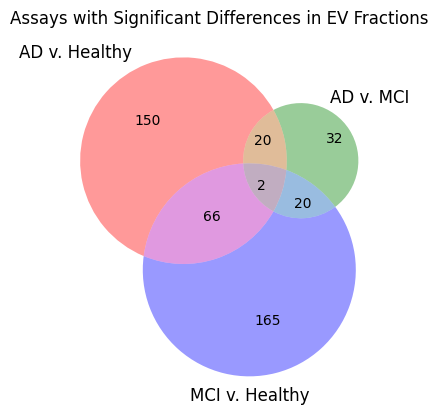

In [335]:
venn3(
    [
        ad_healthy_ev_sig_dif_assays,
        ad_mci_ev_sig_dif_assays,
        mci_healthy_ev_sig_dif_assays,
    ],
    set_labels=("AD v. Healthy", "AD v. MCI", "MCI v. Healthy"),
)
plt.title("Assays with Significant Differences in EV Fractions")

Text(0.5, 1.0, 'Assays with Significant Differences in Secreted Fractions')

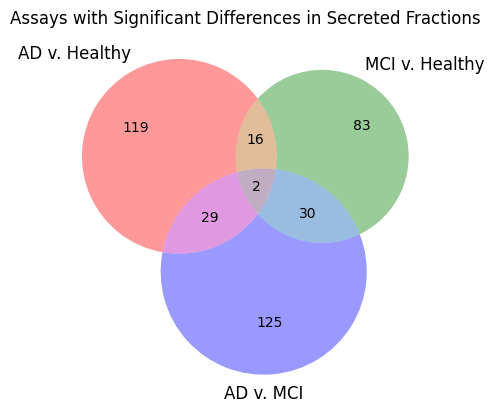

In [336]:
venn3(
    [
        ad_healthy_secreted_sig_dif_assays,
        mci_healthy_secreted_sig_dif_assays,
        ad_mci_secreted_sig_dif_assays,
    ],
    set_labels=("AD v. Healthy", "MCI v. Healthy", "AD v. MCI"),
)
plt.title("Assays with Significant Differences in Secreted Fractions")

Text(0.5, 1.0, 'Assays with Significant Differences Between Sample Groups')

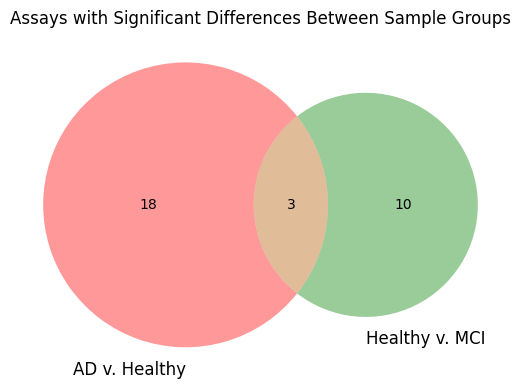

In [337]:
venn2(
    [
        (ad_healthy_ev_sig_dif_assays & ad_healthy_secreted_sig_dif_assays),
        (mci_healthy_ev_sig_dif_assays & mci_healthy_secreted_sig_dif_assays),
    ],
    set_labels=("AD v. Healthy", "Healthy v. MCI"),
)
plt.title("Assays with Significant Differences Between Sample Groups")

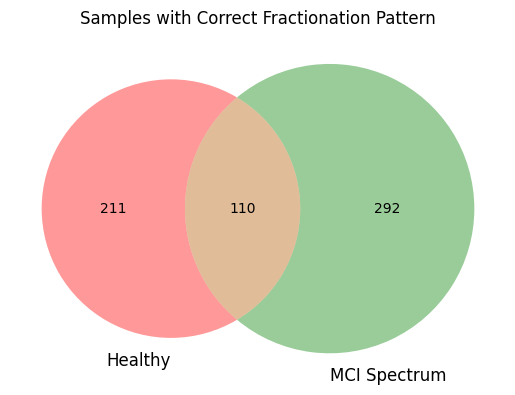

In [338]:
# Healthy vs. MCI Spectrum Fractionation
healthy_ev_fractions = tidy_data[
    (
        (tidy_data.index.get_level_values("Sample") == "SEC Fract 9")
        | (tidy_data.index.get_level_values("Sample") == "SEC Fract 10")
    )
    & (tidy_data.index.get_level_values("Health") == "Healthy")
]

healthy_fract6 = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 6 ")
    & (tidy_data.index.get_level_values("Health") == "Healthy")
]

healthy_fract11 = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 11")
    & (tidy_data.index.get_level_values("Health") == "Healthy")
]

healthy_fract12 = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 12")
    & (tidy_data.index.get_level_values("Health") == "Healthy")
]

healthy_fract13 = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 13")
    & (tidy_data.index.get_level_values("Health") == "Healthy")
]

mci_ev_fractions = tidy_data[
    (
        (tidy_data.index.get_level_values("Sample") == "SEC Fract 9")
        | (tidy_data.index.get_level_values("Sample") == "SEC Fract 10")
    )
    & (tidy_data.index.get_level_values("Health") == "MCI")
]

mci_fract6 = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 6 ")
    & (
        (tidy_data.index.get_level_values("Health") == "MCI")
        | (tidy_data.index.get_level_values("Health") == "AD")
    )
]

mci_fract11 = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 11")
    & (
        (tidy_data.index.get_level_values("Health") == "MCI")
        | (tidy_data.index.get_level_values("Health") == "AD")
    )
]

mci_fract12 = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 12")
    & (
        (tidy_data.index.get_level_values("Health") == "MCI")
        | (tidy_data.index.get_level_values("Health") == "AD")
    )
]

mci_fract13 = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 13")
    & (
        (tidy_data.index.get_level_values("Health") == "MCI")
        | (tidy_data.index.get_level_values("Health") == "AD")
    )
]


healthy_fractionation = []
mci_fractionation = []


for assay in list(tidy_data.columns):
    healthy_ev_fraction_median = healthy_ev_fractions[assay].median()
    healthy_fract6_median = healthy_fract6[assay].median()
    healthy_fract11_median = healthy_fract11[assay].median()
    healthy_fract12_median = healthy_fract12[assay].median()
    healthy_fract13_median = healthy_fract13[assay].median()
    if (
        (healthy_ev_fraction_median > healthy_fract6_median)
        and (healthy_ev_fraction_median > healthy_fract11_median)
        and (healthy_ev_fraction_median > healthy_fract12_median)
        and (healthy_ev_fraction_median > healthy_fract13_median)
    ):
        healthy_fractionation.append(assay)
    mci_ev_fraction_median = mci_ev_fractions[assay].median()
    mci_fract6_median = mci_fract6[assay].median()
    mci_fract11_median = mci_fract11[assay].median()
    mci_fract12_median = mci_fract12[assay].median()
    mci_fract13_median = mci_fract13[assay].median()
    if (
        (mci_ev_fraction_median > mci_fract6_median)
        and (mci_ev_fraction_median > mci_fract11_median)
        and (mci_ev_fraction_median > mci_fract12_median)
        and (mci_ev_fraction_median > mci_fract13_median)
    ):
        mci_fractionation.append(assay)

venn2(
    [set(healthy_fractionation), set(mci_fractionation)],
    set_labels=("Healthy", "MCI Spectrum"),
)
plt.title("Samples with Correct Fractionation Pattern")
plt.show()

In [339]:
# All samples fractionation analysis
ev_fractions = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 9")
    | (tidy_data.index.get_level_values("Sample") == "SEC Fract 10")
]
fract6 = tidy_data[(tidy_data.index.get_level_values("Sample") == "SEC Fract 6 ")]
fract11 = tidy_data[(tidy_data.index.get_level_values("Sample") == "SEC Fract 11")]
fract12 = tidy_data[(tidy_data.index.get_level_values("Sample") == "SEC Fract 12")]
fract13 = tidy_data[(tidy_data.index.get_level_values("Sample") == "SEC Fract 13")]

correct_fractionation = []

for assay in list(tidy_data.columns):
    ev_fraction_median = ev_fractions[assay].median()
    fract6_median = fract6[assay].median()
    fract11_median = fract11[assay].median()
    fract12_median = fract12[assay].median()
    fract13_median = fract13[assay].median()
    if (
        (ev_fraction_median > fract6_median)
        and (ev_fraction_median > fract11_median)
        and (ev_fraction_median > fract12_median)
        and (ev_fraction_median > fract13_median)
    ):
        correct_fractionation.append(assay)

In [340]:
# Overlap between median assays, brain rna seq, and internal only tmhmm

# Internal microglia
internal_microglia_targets = (
    set(correct_fractionation) & set(microglia_uniprots) & set(inside_uniprots)
)

# Internal astrocyte
internal_astrocyte_targets = (
    set(correct_fractionation)
    & set(astrocyte_uniprots)
    & set(inside_uniprots)
)

# Internal oligodendrocyte
internal_oligodendrocyte_targets = (
    set(correct_fractionation) & set(oligodendrocyte_uniprots) & set(inside_uniprots)
)

# Internal neuron
internal_neuron_targets = (
    set(correct_fractionation) & set(neuron_uniprots) & set(inside_uniprots)
)

In [341]:
def graph_medians(uniprot_id):
    df = tidy_data[uniprot_id]
    df = df.reset_index(level=["SampleID", "Health", "Sample"])

    df["Sample"] = pd.Categorical(df["Sample"], categories=CSF_SAMPLES, ordered=True)

    df_sorted = df.sort_values("Sample")

    grouped_data = [
        group[uniprot_id].values for name, group in df_sorted.groupby("Sample")
    ]

    plt.boxplot(grouped_data, notch=None, vert=None, patch_artist=None, widths=None)

    plt.xlabel("Sample Description")

    plt.ylabel("Delta")

    plt.title(f"{uniprot_id} Fractionation Pattern")

    plt.xticks(range(1, len(CSF_SAMPLES) + 1), CSF_SAMPLES)

    plt.xticks(rotation=45, ha="right")

    plt.show()

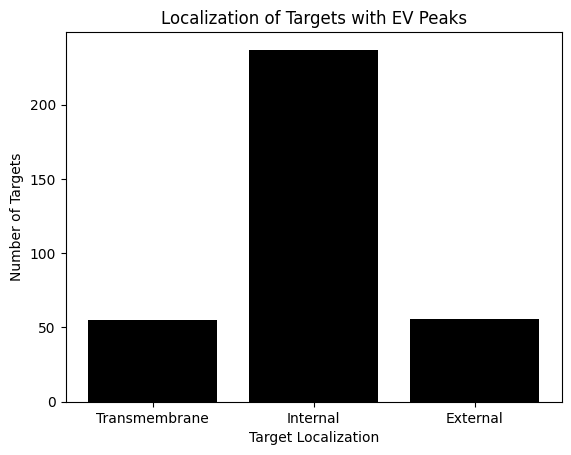

In [342]:
tm_peak = set(tm_uniprots) & set(correct_fractionation)
internal_peak = set(inside_uniprots) & set(correct_fractionation)
external_peak = set(outside_uniprots) & set(correct_fractionation)

peak_dict = {
    "Transmembrane": len(tm_peak),
    "Internal": len(internal_peak),
    "External": len(external_peak),
}

x_labels = list(peak_dict.keys())
y_labels = list(peak_dict.values())

plt.bar(x_labels, y_labels, color="black")
plt.xlabel("Target Localization")
plt.ylabel("Number of Targets")
plt.title("Localization of Targets with EV Peaks")
plt.show()

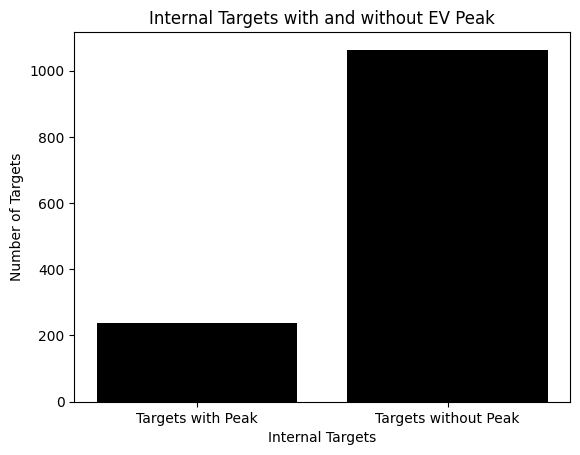

In [343]:
internal_with_peak = set(inside_uniprots) & set(correct_fractionation)
internal_without_peak = set(inside_uniprots) - set(correct_fractionation)

int_dict = {
    "Targets with Peak": len(internal_with_peak),
    "Targets without Peak": len(internal_without_peak),
}

x_labels = list(int_dict.keys())
y_labels = list(int_dict.values())

plt.bar(x_labels, y_labels, color="black")
plt.xlabel("Internal Targets")
plt.ylabel("Number of Targets")
plt.title("Internal Targets with and without EV Peak")
plt.show()

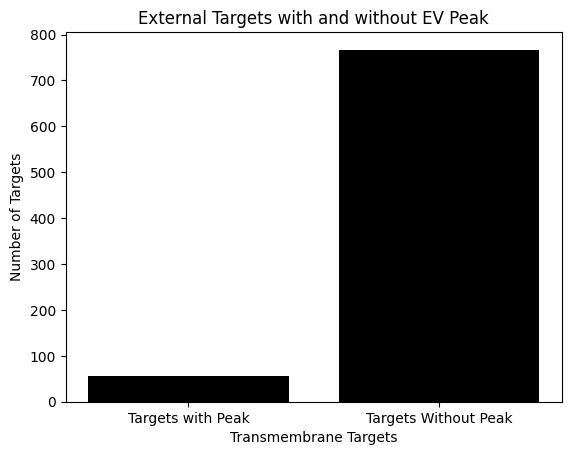

In [344]:
external_with_peak = set(outside_uniprots) & set(correct_fractionation)
external_without_peak = set(outside_uniprots) - set(correct_fractionation)

ext_dict = {
    "Targets with Peak": len(external_with_peak),
    "Targets Without Peak": len(external_without_peak),
}

x_labels = list(ext_dict.keys())
y_labels = list(ext_dict.values())

plt.bar(x_labels, y_labels, color="black")
plt.xlabel("Transmembrane Targets")
plt.ylabel("Number of Targets")
plt.title("External Targets with and without EV Peak")
plt.show()

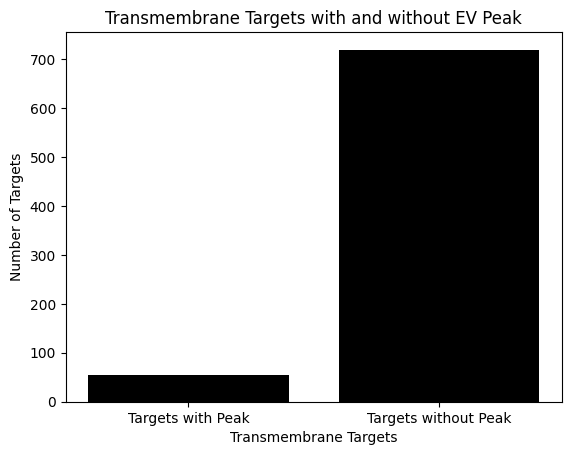

In [345]:
tm_with_peak = set(tm_uniprots) & set(correct_fractionation)
tm_without_peak = set(tm_uniprots) - set(correct_fractionation)

tm_dict = {
    "Targets with Peak": len(tm_with_peak),
    "Targets without Peak": len(tm_without_peak),
}

x_labels = list(tm_dict.keys())
y_labels = list(tm_dict.values())

plt.bar(x_labels, y_labels, color="black")
plt.xlabel("Transmembrane Targets")
plt.ylabel("Number of Targets")
plt.title("Transmembrane Targets with and without EV Peak")
plt.show()

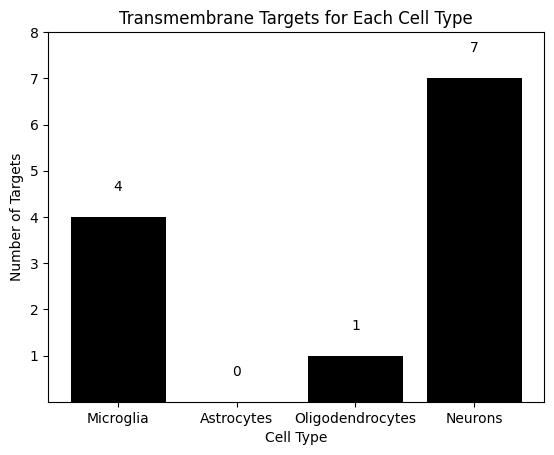

In [346]:
# Overlap between median assays, brain rna seq, and transmembrane targets

# TM microglia
tm_microglia_targets = (
    set(correct_fractionation) & set(microglia_uniprots) & set(tm_uniprots)
)

# TM astrocyte
tm_astrocyte_targets = (
    set(correct_fractionation) & set(astrocyte_uniprots) & set(tm_uniprots)
)

# TM oligodendrocyte
tm_oligodendrocyte_targets = (
    set(correct_fractionation) & set(oligodendrocyte_uniprots) & set(tm_uniprots)
)

# TM neuron
tm_neuron_targets = (
    set(correct_fractionation) & set(neuron_uniprots) & set(tm_uniprots)
)

# number of transmembrane targets per cell type

internal_dict = {
    "Microglia": len(tm_microglia_targets),
    "Astrocytes": len(tm_astrocyte_targets),
    "Oligodendrocytes": len(tm_oligodendrocyte_targets),
    "Neurons": len(tm_neuron_targets),
}

x_labels = list(internal_dict.keys())
y_labels = list(internal_dict.values())

plt.bar(x_labels, y_labels, color="black")

for i, v in enumerate(y_labels):
    plt.text(i, v + 0.5, str(v), ha="center", va="bottom")

plt.yticks([1, 2, 3, 4, 5, 6, 7, 8])

plt.xlabel("Cell Type")
plt.ylabel("Number of Targets")
plt.title("Transmembrane Targets for Each Cell Type")
plt.show()

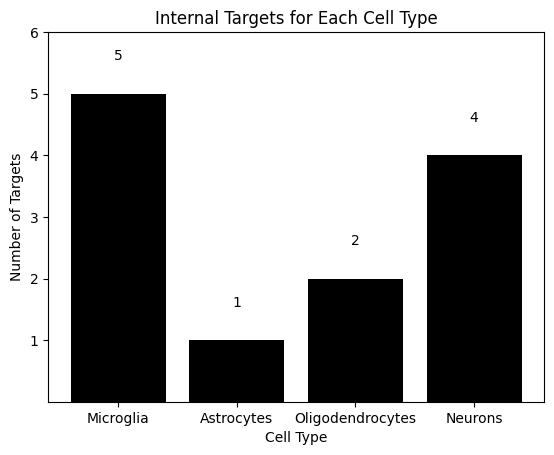

In [353]:
# Overlap between median assays, brain rna seq, and internal only tmhmm

# Internal microglia
internal_microglia_targets = (
    set(correct_fractionation) & set(microglia_uniprots) & set(inside_uniprots)
)

# Internal astrocyte
internal_astrocyte_targets = (
    set(correct_fractionation)
    & set(astrocyte_uniprots)
    & set(inside_uniprots)
)

# Internal oligodendrocyte
internal_oligodendrocyte_targets = (
    set(correct_fractionation) & set(oligodendrocyte_uniprots) & set(inside_uniprots)
)

# Internal neuron
internal_neuron_targets = (
    set(correct_fractionation) & set(neuron_uniprots) & set(inside_uniprots)
)

# number of internal targets per cell type

internal_dict = {
    "Microglia": len(internal_microglia_targets),
    "Astrocytes": len(internal_astrocyte_targets),
    "Oligodendrocytes": len(internal_oligodendrocyte_targets),
    "Neurons": len(internal_neuron_targets),
}

x_labels = list(internal_dict.keys())
y_labels = list(internal_dict.values())

plt.bar(x_labels, y_labels, color="black")

for i, v in enumerate(y_labels):
    plt.text(i, v + 0.5, str(v), ha="center", va="bottom")

plt.yticks([1, 2, 3, 4, 5, 6])

plt.xlabel("Cell Type")
plt.ylabel("Number of Targets")
plt.title("Internal Targets for Each Cell Type")
plt.show()

In [371]:
tm_neuron_targets

{'P01732', 'P04234', 'P07306', 'P17643', 'Q99250', 'Q9NY59', 'Q9NY72'}

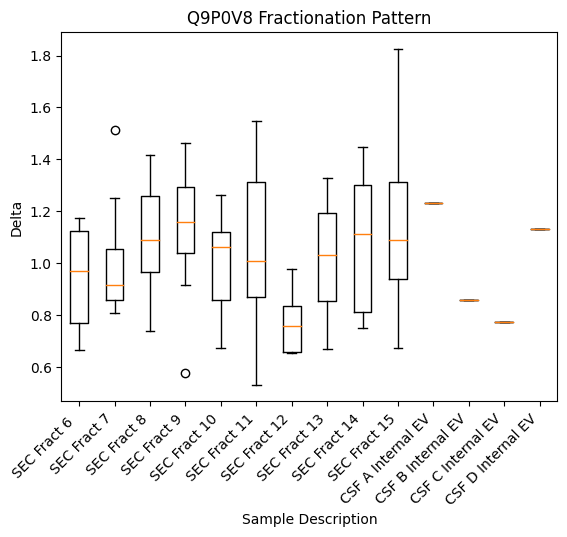

In [370]:
graph_medians("Q9P0V8")